In [ ]:
#Uncomment to install ydata-synthetic lib
! pip install ydata-synthetic

# Time Series synthetic data generation with TimeGAN



In [6]:
#Importing the required libs for the exercise

from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers import ModelParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeGAN

## Define Model hyperparameters

**Networks:**
- Generator
- Discriminator
- Embedder
- Recovery Network

TimeGAN is a Generative model based on RNN networks. In this package the implemented version follows a very simple architecture that is shared by the four elements of the GAN.

Similarly to other parameters, the architectures of each element should be optimized and tailored to the data.

In [52]:
#Specific to TimeGANs
seq_len=24
n_seq = 2
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim)

## The data

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/sb01.csv')
cols = ['counts', 'speed']
data_df = df.loc[df.index, cols]
data_df = data_df.interpolate()
data_df

In [66]:
data_df.to_csv('real_sb01.csv', index = False)

In [83]:
real_data = processed_stock(path='/content/real_sb01.csv', seq_len=seq_len)
print(len(real_data),stock_data[0].shape)

342 (24, 2)


## Training the TimeGAN synthetizer

In [85]:
if path.exists('synthesizer.pkl'):
    synth = TimeGAN.load('synthesizer.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(real_data, train_steps=1000)
    synth.save('synthesizer.pkl')

Joint networks training: 100%|██████████| 1000/1000 [26:51<00:00,  1.61s/it]


### The generated synthetic data

In [86]:
synth_data = synth.sample(len(real_data))
print(synth_data.shape)

Synthetic data generation: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

(384, 24, 2)


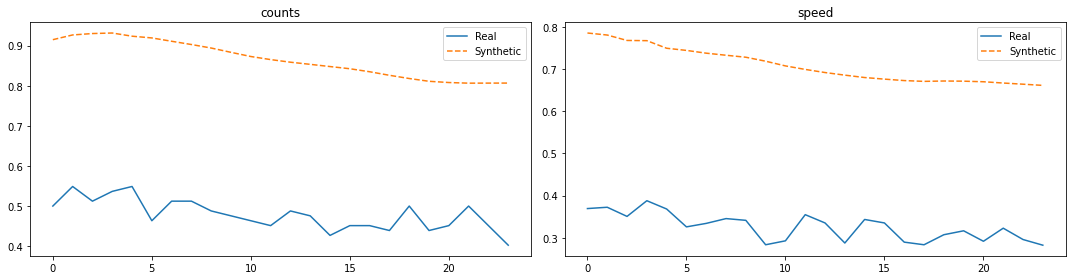

In [89]:
#Reshaping the data
cols = ['counts', 'speed']

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes=axes.flatten()

time = list(range(1,366))
obs = np.random.randint(len(real_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': real_data[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

#### Evaluation of the generated synthetic data (PCA and TSNE)

In [90]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
real_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(real_data_reduced)

pca_real = pd.DataFrame(pca.transform(real_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((real_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

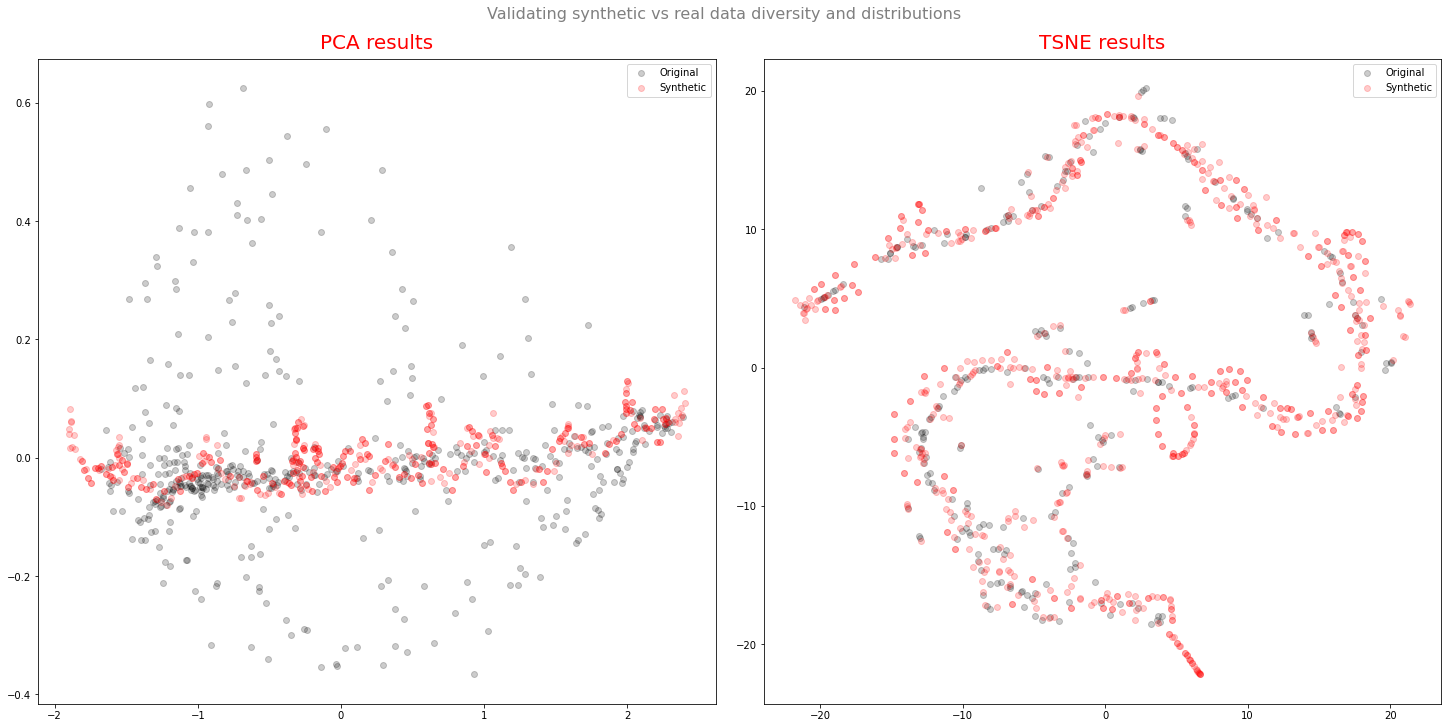

In [91]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

#### Train synthetic test real (TSTR)

In [92]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

#First implement a simple RNN model for prediction
def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    model = Sequential()
    model.add(GRU(units=units,
                  name=f'RNN_1'))
    model.add(Dense(units=2,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [95]:
#Prepare the dataset for the regression model
stock_data=np.asarray(real_data)
synth_data = synth_data[:len(real_data)]
n_events = len(real_data)

#Split data on train and test
idx = np.arange(n_events)
n_train = int(.75*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

#Define the X for synthetic and real data
X_real_train = real_data[train_idx, :seq_len-1, :]
X_synth_train = synth_data[train_idx, :seq_len-1, :]

X_real_test = real_data[test_idx, :seq_len-1, :]
y_real_test = real_data[test_idx, -1, :]

#Define the y for synthetic and real datasets
y_real_train = real_data[train_idx, -1, :]
y_synth_train = synth_data[train_idx, -1, :]

print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Real X train: {}'.format(X_real_train.shape))

print('Synthetic y train: {}'.format(y_synth_train.shape))
print('Real y train: {}'.format(y_real_train.shape))

print('Real X test: {}'.format(X_real_test.shape))
print('Real y test: {}'.format(y_real_test.shape))

In [79]:
#Training the model with the real train data
ts_real = RNN_regression(12)
early_stopping = EarlyStopping(monitor='val_loss')

real_train = ts_real.fit(x=X_real_train,
                          y=y_real_train,
                          validation_data=(X_real_test, y_real_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
2/2 [==============================] - 3s 787ms/step - loss: 0.2384 - val_loss: 0.2702
Epoch 2/200
2/2 [==============================] - 0s 82ms/step - loss: 0.2352 - val_loss: 0.2674
Epoch 3/200
2/2 [==============================] - 0s 85ms/step - loss: 0.2303 - val_loss: 0.2647
Epoch 4/200
2/2 [==============================] - 0s 103ms/step - loss: 0.2275 - val_loss: 0.2619
Epoch 5/200
2/2 [==============================] - 0s 81ms/step - loss: 0.2282 - val_loss: 0.2591
Epoch 6/200
2/2 [==============================] - 0s 80ms/step - loss: 0.2263 - val_loss: 0.2563
Epoch 7/200
2/2 [==============================] - 0s 97ms/step - loss: 0.2218 - val_loss: 0.2535
Epoch 8/200
2/2 [==============================] - 0s 85ms/step - loss: 0.2235 - val_loss: 0.2509
Epoch 9/200
2/2 [==============================] - 0s 84ms/step - loss: 0.2133 - val_loss: 0.2483
Epoch 10/200
2/2 [==============================] - 0s 76ms/step - loss: 0.2120 - val_loss: 0.2458
Epoch 11/200
2/2 

In [81]:
#Training the model with the synthetic data
ts_synth = RNN_regression(12)
synth_train = ts_synth.fit(x=X_synth_train,
                          y=y_synth_train,
                          validation_data=(X_train_test, y_train_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
2/2 [==============================] - 2s 722ms/step - loss: 0.2198 - val_loss: 0.2244
Epoch 2/200
2/2 [==============================] - 0s 144ms/step - loss: 0.2232 - val_loss: 0.2226
Epoch 3/200
2/2 [==============================] - 0s 124ms/step - loss: 0.2190 - val_loss: 0.2211
Epoch 4/200
2/2 [==============================] - 0s 86ms/step - loss: 0.2199 - val_loss: 0.2196
Epoch 5/200
2/2 [==============================] - 0s 105ms/step - loss: 0.2175 - val_loss: 0.2180
Epoch 6/200
2/2 [==============================] - 0s 100ms/step - loss: 0.2173 - val_loss: 0.2164
Epoch 7/200
2/2 [==============================] - 0s 77ms/step - loss: 0.2190 - val_loss: 0.2148
Epoch 8/200
2/2 [==============================] - 0s 194ms/step - loss: 0.2177 - val_loss: 0.2133
Epoch 9/200
2/2 [==============================] - 0s 82ms/step - loss: 0.2162 - val_loss: 0.2118
Epoch 10/200
2/2 [==============================] - 0s 78ms/step - loss: 0.2111 - val_loss: 0.2103
Epoch 11/200


In [82]:
#Summarize the metrics here as a pandas dataframe
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error
real_predictions = ts_real.predict(X_real_test)
synth_predictions = ts_synth.predict(X_real_test)

metrics_dict = {'r2': [r2_score(y_real_test, real_predictions),
                       r2_score(y_real_test, synth_predictions)],
                'MAE': [mean_absolute_error(y_real_test, real_predictions),
                        mean_absolute_error(y_real_test, synth_predictions)],
                'MRLE': [mean_squared_log_error(y_real_test, real_predictions),
                         mean_squared_log_error(y_real_test, synth_predictions)]}

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic'])

results

,r2,MAE,MRLE
Real,0.981124,0.028782,0.000599
Synthetic,0.864683,0.082656,0.004054
